In [21]:
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline

In [1]:
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi
from allensdk.core.cell_types_cache import ReporterStatus as RS

# Instantiate the CellTypesCache instance.  The manifest_file argument
# tells it where to store the manifest, which is a JSON file that tracks
# file paths.  If you supply a relative path (like this), it will go
# into your current working directory
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')

In [175]:
cells = ctc.get_cells()

In [259]:
filter_frame = lambda frame, str : frame.drop(list(frame.filter(regex = str)), axis = 1)
ephys_features = ctc.get_ephys_features(dataframe=True)
ef_df = ephys_features.drop(['has_delay'], axis=1)
ef_df.set_index('specimen_id', inplace=True)
ef_df = filter_frame(ef_df, 'id')

# get morphology features for reconstructed cells
morphology_features = ctc.get_morphology_features(dataframe=True)
mf_df = morphology_features.drop(
    ['average_bifurcation_angle_remote', 'hausdorff_dimension'], axis=1)
mf_df = filter_frame(mf_df, 'scale_factor')
mf_df.set_index('specimen_id', inplace=True)
mf_df = filter_frame(mf_df, 'id')
# or download both morphology and ephys features at the same time
# all_features = ctc.get_all_features(dataframe=True, require_reconstruction=True)

In [260]:
# find matches
ids = [c['id'] for c in cells]
in_both = list(set(ids).intersection(set(ef_df.index)))
# get info about each cell
cell_type = list()
for cid in in_both:
    this_cell = cell_index[cid]
    this_donor = this_cell['donor']
    cell_type.append((this_cell['dendrite_type'],
                     this_cell['structure']['acronym'],
                     this_donor['sex_full_name'],
                     this_donor['age_id'],
                     this_cell['transgenic_line']))
# convert to dataframe
ct_df = pd.DataFrame(columns=['spines','structure', 'sex', 'age_id', 'transgenic_line'],
                     data=cell_type, index=in_both)
ct_df.head()

,spines,structure,sex,age_id,transgenic_line
480116737,spiny,VISp5,Male,20,Rorb-IRES2-Cre
318543876,aspiny,VISp4,Male,298414240,Pvalb-IRES-Cre
471767045,spiny,VISp5,Male,298414240,Rbp4-Cre_KL100
485287944,spiny,VISp6a,Female,97,Ntsr1-Cre_GN220
481099785,aspiny,VISp4,Male,20,Htr3a-Cre_NO152


In [373]:
# make sure both have same index
X = ef_df.loc[in_both, :]
Y = ct_df.loc[in_both,:]
threshold = 50
vc = Y.structure.value_counts()
structures_to_keep = vc[vc >= threshold].index.values
to_keep = Y['structure'].isin(structures_to_keep)
Y = Y.loc[to_keep, :]
X = X.loc[to_keep, :]

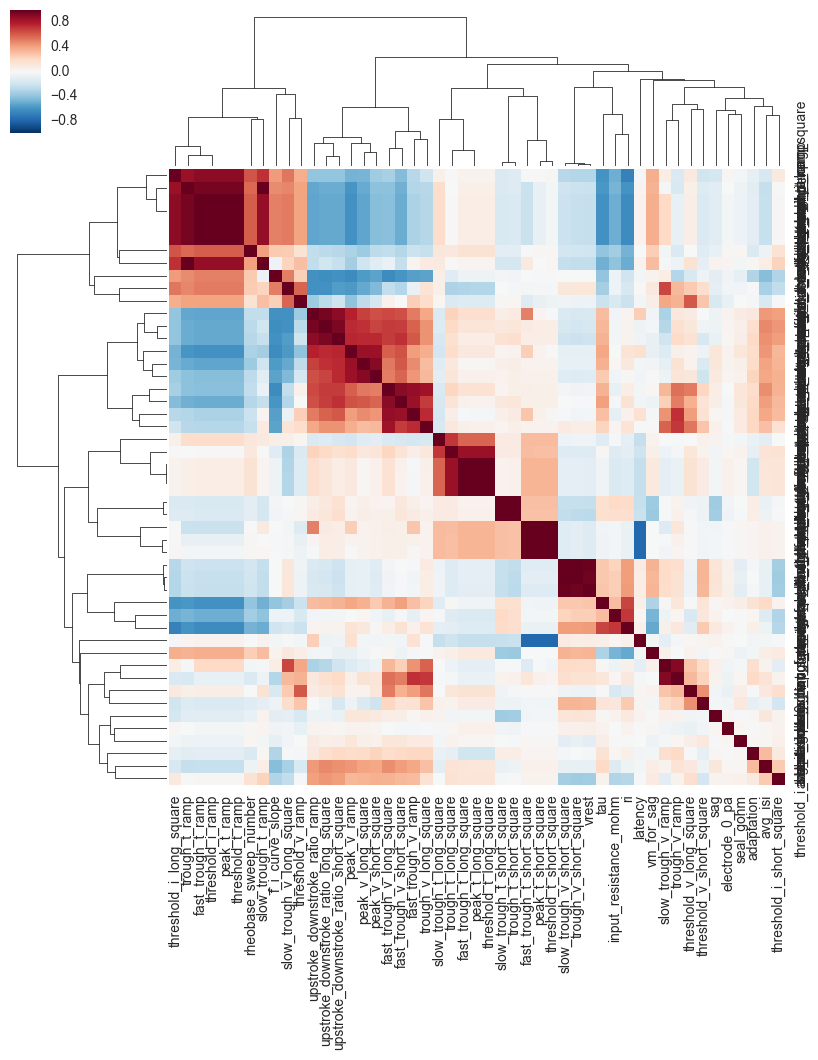

In [372]:
sns.clustermap(X.corr())

In [374]:
# remove cells with lots of NaNs
bad_cells = pd.isna(X[['fast_trough_t_ramp',
                       'electrode_0_pa',
                       'slow_trough_t_short_square']]).any(axis=1)
Y = Y.loc[~bad_cells]
X = X.loc[~bad_cells, :]
# remove categories with lots of NaNs
X.drop(X.columns[np.sum(pd.isna(X)) > 50], axis=1, inplace=True)

In [375]:
from sklearn.preprocessing import RobustScaler
X = RobustScaler().fit_transform(X)

In [341]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
skf = StratifiedKFold(n_splits=5)
model = RidgeClassifier(alpha=2)

scores = cross_val_score(model, X, Y.structure, cv=skf)

In [342]:
scores

array([ 0.50847458,  0.51977401,  0.57142857,  0.52      ,  0.54022989])

In [346]:
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y.structure,
                                                    train_size=0.75, test_size=0.25)

In [348]:
tpot = TPOTClassifier(verbosity=2, max_time_mins=5)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

/Users/davidhbrann/anaconda3/envs/allen/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/davidhbrann/anaconda3/envs/allen/lib/python2.7/site-packages/xgboost/training.py:11: ImportWarning: Not importing directory '/Users/davidhbrann/anaconda3/envs/allen/lib/python2.7/site-packages/xgboost/rabit': missing __init__.py
  from . import rabit
/Users/davidhbrann/anaconda3/envs/allen/lib/python2.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/davidhbra


5.06028386667 minutes have elapsed. TPOT will close down.
TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestClassifier(MaxAbsScaler(input_matrix), bootstrap=True, criterion=entropy, max_features=0.8, min_samples_leaf=11, min_samples_split=12, n_estimators=100)


ValueError: could not convert string to float: VISp5

In [352]:
tpot.fitted_pipeline_

Pipeline(memory=None,
     steps=[('maxabsscaler', MaxAbsScaler(copy=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            m...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [381]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MaxAbsScaler
model = RandomForestClassifier(bootstrap=True, criterion='entropy',
                               max_features=0.8, min_samples_leaf=11,
                               min_samples_split=12, n_estimators=100)
# only evaluate spiny
scores = cross_val_score(model, X[np.where(Y.spines=='spiny')[0], :], Y.loc[Y.spines=='spiny', 'structure'], cv=skf)
print(scores)
scores.mean()

[ 0.59405941  0.56435644  0.68686869  0.58585859  0.52040816]


0.59031025551534744